In [23]:
import pandas as pd
from utils import drop_skewed_features, drop_correlated_features
from aencoder import Autoencoder
from aencoder import train_autoencoder, get_latent_representation
import torch
import os

In [2]:
df = pd.read_csv('/Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/final_embedding/cl2/cl2_full_dataset.csv')

opt_params = {'silhouette_score': 0.5902, 'num_clusters': 9, 'skew_threshold': 0.8, 'corr_threshold': 0.5, 'hidden_size': 64, 'latent_dim': 2, 'learning_rate': 0.01, 'epochs': 500, 'hdbscan_params': {'min_cluster_size': 5, 'min_samples': 25}, 'dataset': 5}

In [3]:
df

,Unnamed: 0,Symptom_Memory_short,Symptom_Memory_long,Symptom_Memory_no_new_memories,Symptom_Memory_forget_tasks,Symptom_Memory_other,Symptom_Cognitive_Functioning_thinking,Symptom_Cognitive_Functioning_executive,Symptom_Cognitive_Functioning_problemsolving,Symptom_Cognitive_Functioning_slowedthoughts,...,Demographics_Age_Cleaned,Flag_MECFS,Flag_POTS,Flag_MCAS,FAS,FAS_cat,Physical_PEM_Severity,Cognitive_PEM_Severity,HasPeriods,cluster
0,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,30-39,1.0,"No, no tachycardia",1.0,20.0,Minimal/No Fatigue,5.0,5.0,NaN,1
1,5,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,40-49,1.0,"No, no tachycardia",0.0,30.0,Fatigue,9.0,7.0,"No, other reason",1
2,6,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,40-49,1.0,"Possible, had tachycardia/palpitations",0.0,20.0,Minimal/No Fatigue,8.0,0.0,"No, other reason",5
3,8,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,40-49,1.0,"Definite, measured bpm > 30",0.0,19.0,Minimal/No Fatigue,7.0,4.0,Yes,1
4,9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,40-49,1.0,"Possible, had tachycardia/palpitations",0.0,20.0,Minimal/No Fatigue,10.0,0.0,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6026,14158,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,50-59,1.0,"Possible, had tachycardia/palpitations",2.0,32.0,Fatigue,8.0,6.0,"No, post-menopausal",0
6027,14161,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,30-39,1.0,"Likely, had higher bpm standing",1.0,26.0,Fatigue,10.0,9.0,"No, other reason",4
6028,14163,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,30-39,0.0,"Definite, measured bpm > 30",1.0,33.0,Fatigue,8.0,7.0,Yes,1
6029,14166,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,60-69,0.0,"No, no tachycardia",0.0,18.0,Minimal/No Fatigue,NaN,NaN,NaN,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6031 entries, 0 to 6030
Columns: 176 entries, Unnamed: 0 to cluster
dtypes: float64(71), int64(99), object(6)
memory usage: 8.1+ MB


In [5]:
def calculate_cluster_sizes(df):
    """
    Calculate the sizes of each cluster in the DataFrame.

    Parameters:
    df (DataFrame): A pandas DataFrame with a 'cluster' column.

    Returns:
    Series: A pandas Series with cluster labels as index and their respective sizes as values.
    """
    cluster_sizes = df.groupby('cluster').size()
    return cluster_sizes

In [6]:
calculate_cluster_sizes(df)

cluster
-1     222
 0    1125
 1    2126
 2     321
 3     498
 4     850
 5     889
dtype: int64

In [7]:
def average_symptom_count_by_cluster(df):
    """
    Calculate the average symptom count for each cluster in the DataFrame.

    Parameters:
    df (DataFrame): A pandas DataFrame with columns for symptoms starting with "Symptom_" and a 'cluster' column.

    Returns:
    DataFrame: A pandas DataFrame with the average symptom count for each cluster.
    """
    # Filter columns that start with 'Symptom_'
    symptom_columns = [col for col in df.columns if col.startswith('Symptom_')]

    # Sum the symptom columns for each row
    df['total_symptoms'] = df[symptom_columns].sum(axis=1)

    # Calculate the average symptom count for each cluster
    average_symptoms = round(df.groupby('cluster')['total_symptoms'].mean(),0)

    return average_symptoms

# Example usage
# Assuming you have your DataFrame loaded as 'df'
average_symptoms = average_symptom_count_by_cluster(df)
print(average_symptoms)


cluster
-1    16.0
 0    44.0
 1    60.0
 2    35.0
 3    46.0
 4    28.0
 5    37.0
Name: total_symptoms, dtype: float64


In [8]:
for col in df.columns:
    print(col)

Unnamed: 0
Symptom_Memory_short
Symptom_Memory_long
Symptom_Memory_no_new_memories
Symptom_Memory_forget_tasks
Symptom_Memory_other
Symptom_Cognitive_Functioning_thinking
Symptom_Cognitive_Functioning_executive
Symptom_Cognitive_Functioning_problemsolving
Symptom_Cognitive_Functioning_slowedthoughts
Symptom_Cognitive_Functioning_fastthoughts
Symptom_Cognitive_Functioning_agnosia
Symptom_Cognitive_Functioning_attentionconcentration
Symptom_Cognitive_Functioning_other
Symptom_Speech_difficulty_finding_words
Symptom_Speech_difficulty_communicating_verbally
Symptom_Speech_difficulty_reading_processing_text
Symptom_Speech_difficulty_understanding_others_speech
Symptom_Speech_difficulty_speaking_complete_sentences
Symptom_Speech_speaking_unrecognizable_words
Symptom_Speech_difficulty_communicating_writing
Symptom_Speech_changes_to_secondary_languages
Symptom_Speech_other
Symptom_Headaches_behind_eyes
Symptom_Headaches_stiff_neck
Symptom_Headaches_brain_pressure
Symptom_Headaches_diffuse
Symp

In [57]:
df["Demographics_Gender_Cleaned"].value_counts()

Demographics_Gender_Cleaned
Woman                                           4703
Man                                             1205
Non-binary/Genderqueer/Gender non-conforming     100
Name: count, dtype: int64

In [10]:
df["Demographics_Age_Cleaned"].value_counts()

Demographics_Age_Cleaned
40-49    1725
50-59    1460
30-39    1352
60-69     736
18-29     526
70-79     213
80+        19
Name: count, dtype: int64

In [11]:
def average_women_to_other_ratio_by_cluster(df):
    """
    Calculate the average ratio of 'Women' to 'Other' for each cluster in the DataFrame.

    Parameters:
    df (DataFrame): A pandas DataFrame with a 'Demographics_Gender_Cleaned' and a 'cluster' column.

    Returns:
    Series: A pandas Series with cluster labels as index and the average ratio of 'Women' to 'Other' as values.
    """
    # Create a new column for 'Woman' (1) and 'Other' (0)
    df['woman_or_other'] = df['Demographics_Gender_Cleaned'].apply(lambda x: 1 if x == 'Woman' else 0)

    # Calculate the average ratio for each cluster
    average_ratios = round(df.groupby('cluster')['woman_or_other'].mean(),3)

    return average_ratios

average_women_to_other_ratio_by_cluster(df)

cluster
-1    0.667
 0    0.795
 1    0.830
 2    0.791
 3    0.791
 4    0.714
 5    0.721
Name: woman_or_other, dtype: float64

In [12]:
def convert_age(age_string):
    conversion_dict = {
        '30-39': 35,
        '40-49': 45,
        '50-59': 55,
        '18-29': 24,
        '60-69': 65,
        '70-79': 75,
        '80+': 85
    }
    return conversion_dict[age_string]

def average_age_by_cluster(df):
    """
    Calculate the average age for each cluster in the DataFrame, rounded to one decimal place.

    Parameters:
    df (DataFrame): A pandas DataFrame with a 'Demographics_Age_Cleaned' and a 'cluster' column.

    Returns:
    DataFrame: A pandas DataFrame with cluster labels as index and the average age as values, rounded to one decimal place.
    """
    # Convert age ranges to average ages
    df['average_age'] = df['Demographics_Age_Cleaned'].apply(convert_age)

    # Calculate the average age for each cluster
    average_ages = df.groupby('cluster')['average_age'].mean().round(1)

    return average_ages

In [13]:
average_age_by_cluster(df)

cluster
-1    47.6
 0    47.3
 1    46.7
 2    45.9
 3    46.3
 4    47.7
 5    47.1
Name: average_age, dtype: float64

In [14]:
df["Cognitive_PEM_Severity"].value_counts()

Cognitive_PEM_Severity
8.0     772
7.0     724
0.0     610
5.0     603
6.0     565
10.0    520
9.0     479
4.0     346
3.0     298
2.0     216
1.0     196
Name: count, dtype: int64

In [58]:
def average_normalized_pem_severity_by_cluster(df):
    """
    Calculate the average normalized PEM severity for each cluster in the DataFrame.

    Parameters:
    df (DataFrame): A pandas DataFrame with a 'Physical_PEM_Severity' column and a 'cluster' column.

    Returns:
    Series: A pandas Series with cluster labels as index and the average normalized PEM severity as values.
    """
    # Normalize the 'Physical_PEM_Severity' column
    df['normalized_pem_severity'] = df['Physical_PEM_Severity'] / 10

    # Calculate the average normalized PEM severity for each cluster
    average_severity = round(df.groupby('cluster')['normalized_pem_severity'].mean(),3)

    return average_severity

average_normalized_pem_severity_by_cluster(df)

cluster
-1    0.619
 0    0.773
 1    0.811
 2    0.747
 3    0.773
 4    0.719
 5    0.735
Name: normalized_pem_severity, dtype: float64

/var/folders/dt/bgs1hq3d2k3dvhpt3llvs4rw0000gn/T/ipykernel_24607/3651291348.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sympdf['cluster'] = clusters.iloc[:, -1]


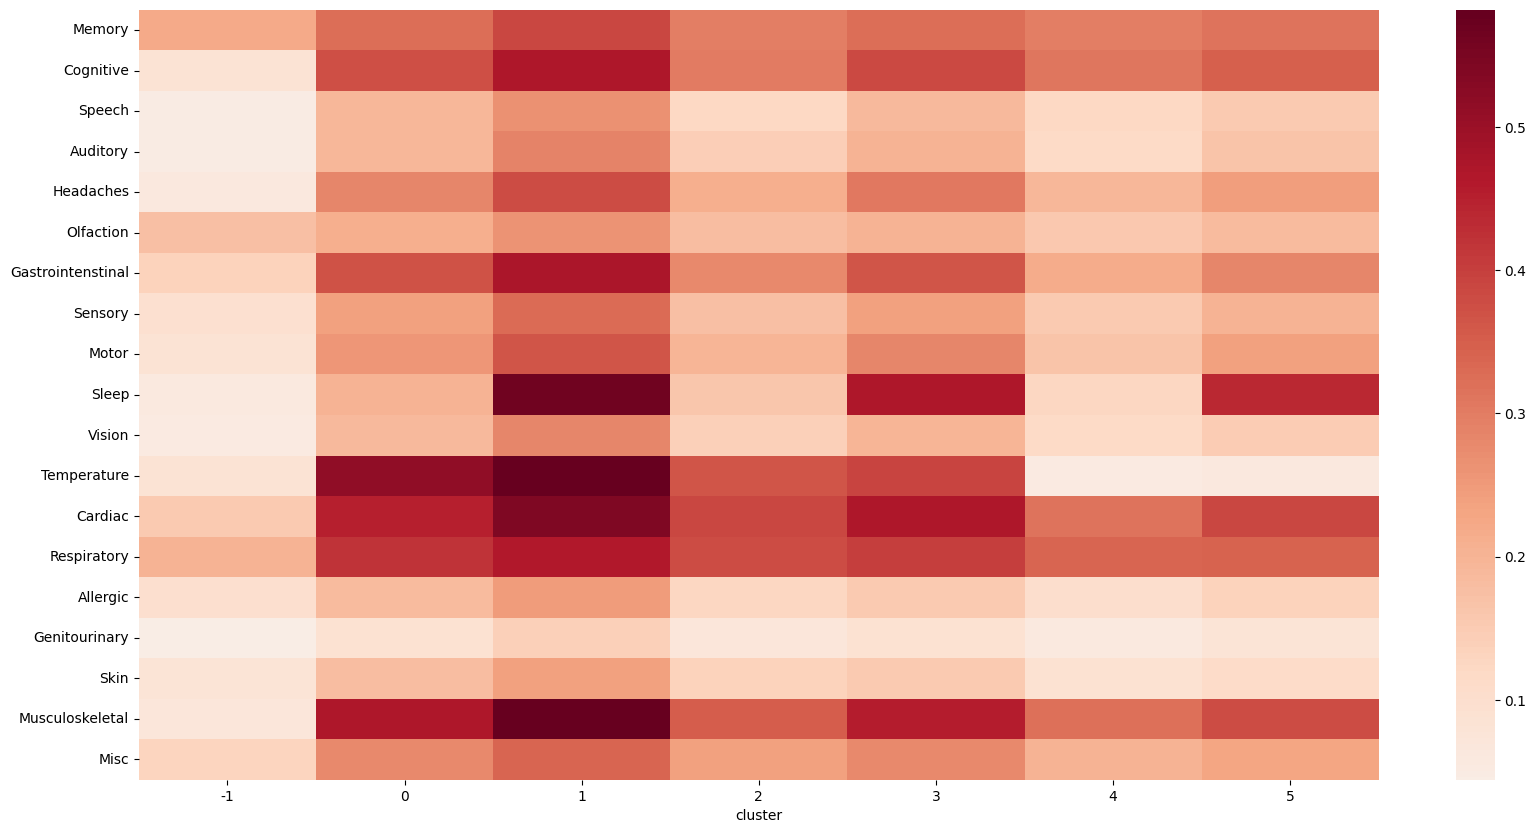

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_symp_group_freq(clusters, symp_groups=None, sympdf=None, include_misc=True, mode="mean", saveloc=None):
    """
    Plot symptom group frequencies by cluster.

    Parameters:
    clusters (str or DataFrame): Path to CSV file with clusters or DataFrame with clusters.
    symp_groups (DataFrame, optional): DataFrame with symptom groups. Default is None.
    sympdf (DataFrame, optional): DataFrame with symptoms. Default is None.
    include_misc (bool): Whether to include 'Misc' group. Default is True.
    mode (str): Aggregation mode, 'mean' by default.
    saveloc (str, optional): Location to save the plot. Default is None.

    Returns:
    DataFrame: Average scores by symptom group.
    """
    # Read clusters from CSV if it's a string
    if isinstance(clusters, str):
        clusters = pd.read_csv(clusters, index_col=0)

    if sympdf is None:
        df = pd.read_csv("/Users/leo/Programming/PLR/Leo/data/cleaned_data_SYMPTOMS_9_13_23.csv", index_col=0)
        sympdf = df.loc[:, df.columns.str.startswith('Symptom_')]

    if symp_groups is None:
        symp_groups = pd.read_csv("/Users/leo/Programming/PLR/clusterings/tessa/symptom_groups.csv")

    if not include_misc:
        symp_groups = symp_groups[symp_groups['group'].isin(['Misc', 'misc']) == False]

    sympdf['cluster'] = clusters.iloc[:, -1]
    
    if mode == "mean":
        avg_scores_by_grouping = {}

        for grouping in symp_groups.group.unique():
            keepcols = symp_groups.loc[symp_groups.group == grouping, 'symptom'].tolist()
            keepcols.append('cluster')
            a = sympdf.loc[:, keepcols]
            avg = a.groupby('cluster').mean()
            avg_scores_by_grouping[grouping] = avg.mean(axis=1)

        avgdf = pd.DataFrame(avg_scores_by_grouping)
        plt.figure(figsize=(20, 10))
        sns.heatmap(avgdf.transpose(), cmap='RdBu_r', center=0)

        if saveloc is not None:
            plt.savefig(saveloc)

        return avgdf

    
avg_df = plot_symp_group_freq("/Users/leo/Programming/PLR/clusterings/leo/final_aencoder_hdbscan_6.csv")

In [17]:
avg_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, -1 to 5
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Memory             7 non-null      float64
 1   Cognitive          7 non-null      float64
 2   Speech             7 non-null      float64
 3   Auditory           7 non-null      float64
 4   Headaches          7 non-null      float64
 5   Olfaction          7 non-null      float64
 6   Gastrointenstinal  7 non-null      float64
 7   Sensory            7 non-null      float64
 8   Motor              7 non-null      float64
 9   Sleep              7 non-null      float64
 10  Vision             7 non-null      float64
 11  Temperature        7 non-null      float64
 12  Cardiac            7 non-null      float64
 13  Respiratory        7 non-null      float64
 14  Allergic           7 non-null      float64
 15  Genitourinary      7 non-null      float64
 16  Skin               7 non-null     

In [18]:
def compute_symptom_group_difference(df):
    """
    Compute the difference in average symptom group scores for each cluster from the overall average.

    Parameters:
    df (DataFrame): DataFrame containing symptom group scores with clusters as rows and symptom groups as columns.

    Returns:
    DataFrame: A DataFrame showing the difference in average symptom group scores for each cluster.
    """
    # Ensure the DataFrame is structured correctly
    if df.index.name != 'cluster':
        df = df.set_index('cluster')

    # Calculate the overall average for each symptom group
    overall_avg = df.mean()

    # Calculate the difference for each cluster
    difference_df = df.subtract(overall_avg, axis='columns')

    return difference_df

# Assuming your DataFrame is named df
# df = your_dataframe_with_clusters_and_symptoms
difference_df = compute_symptom_group_difference(avg_df)

In [19]:
difference_df

,Memory,Cognitive,Speech,Auditory,Headaches,Olfaction,Gastrointenstinal,Sensory,Motor,Sleep,Vision,Temperature,Cardiac,Respiratory,Allergic,Genitourinary,Skin,Musculoskeletal,Misc
cluster,,,,,,,,,,,,,,,,,,,
-1,-0.088953,-0.242303,-0.108142,-0.116082,-0.177627,-0.021108,-0.168638,-0.110291,-0.143528,-0.230829,-0.109369,-0.211547,-0.234836,-0.161525,-0.052995,-0.037314,-0.062577,-0.304602,-0.113839
0,0.016181,0.049315,0.035324,0.026954,0.043862,0.016772,0.066308,0.033534,0.027583,-0.086010,0.029046,0.222023,0.064645,0.054543,0.036772,0.008319,0.038372,0.094674,0.034807
1,0.076256,0.147681,0.111309,0.119746,0.137567,0.066151,0.172373,0.124946,0.138496,0.274676,0.123182,0.288148,0.156750,0.103519,0.097530,0.055653,0.099304,0.205002,0.094507
2,-0.014001,-0.023351,-0.034291,-0.021099,-0.027812,-0.016877,-0.022898,-0.027315,-0.030600,-0.127083,-0.021879,0.072289,0.001697,0.014882,-0.024443,-0.011365,-0.005892,-0.022745,-0.004665
3,0.016735,0.060454,0.031437,0.038687,0.067087,0.008538,0.060851,0.034070,0.055769,0.180693,0.036747,0.099569,0.083193,0.037318,0.004303,0.009104,0.011707,0.080777,0.037811
4,-0.011280,-0.012168,-0.033036,-0.047178,-0.045809,-0.040607,-0.087063,-0.051160,-0.061861,-0.162329,-0.046350,-0.241548,-0.071088,-0.027732,-0.046432,-0.021341,-0.051994,-0.054666,-0.038301
5,0.005061,0.020372,-0.002600,-0.001028,0.002731,-0.012869,-0.020933,-0.003785,0.014140,0.150882,-0.011378,-0.228934,-0.000361,-0.021005,-0.014734,-0.003056,-0.028920,0.001561,-0.010319


In [20]:
avg_df

,Memory,Cognitive,Speech,Auditory,Headaches,Olfaction,Gastrointenstinal,Sensory,Motor,Sleep,Vision,Temperature,Cardiac,Respiratory,Allergic,Genitourinary,Skin,Musculoskeletal,Misc
cluster,,,,,,,,,,,,,,,,,,,
-1,0.221622,0.081982,0.048423,0.050050,0.061712,0.175676,0.134635,0.094595,0.083333,0.058559,0.052177,0.082207,0.152252,0.203266,0.097097,0.044144,0.078829,0.070946,0.128734
0,0.326756,0.373600,0.191889,0.193086,0.283200,0.213556,0.369580,0.238420,0.254444,0.203378,0.190593,0.515778,0.451733,0.419333,0.186864,0.089778,0.179778,0.470222,0.277380
1,0.386830,0.471966,0.267874,0.285879,0.376905,0.262935,0.475645,0.329832,0.365357,0.564064,0.284729,0.581903,0.543838,0.468309,0.247622,0.137112,0.240710,0.580550,0.337080
2,0.296573,0.300935,0.122274,0.145033,0.211526,0.179907,0.280374,0.177570,0.196262,0.162305,0.139668,0.366044,0.388785,0.379673,0.125649,0.070093,0.135514,0.352804,0.237908
3,0.327309,0.384739,0.188002,0.204819,0.306426,0.205321,0.364123,0.238956,0.282631,0.470080,0.198293,0.393323,0.470281,0.402108,0.154395,0.090562,0.153112,0.456325,0.280385
4,0.299294,0.312118,0.123529,0.118954,0.193529,0.156176,0.216209,0.153725,0.165000,0.127059,0.115196,0.052206,0.316000,0.337059,0.103660,0.060118,0.089412,0.320882,0.204272
5,0.315636,0.344657,0.153965,0.165104,0.242070,0.183915,0.282340,0.201100,0.241001,0.440270,0.150169,0.064820,0.386727,0.343785,0.135358,0.078403,0.112486,0.377109,0.232254


In [28]:
RANDOM_SEED = 44

dataset = pd.read_csv(f'/Users/leo/Programming/PLR/Leo/data/dataset_{opt_params["dataset"]}.csv')
original_dataset = dataset.copy()
dataset = drop_skewed_features(dataset, opt_params['skew_threshold'])
dataset_no_skew = dataset.copy()
dataset = drop_correlated_features(dataset, opt_params['corr_threshold'])
dataset_no_corr = dataset.copy()
tensor_dataset = torch.tensor(dataset.values.astype(np.float32))

# Determine the dropped columns
skewed_features_dropped = set(original_dataset.columns) - set(dataset_no_skew.columns)
correlated_features_dropped = set(dataset_no_skew.columns) - set(dataset_no_corr.columns)

# Print the list of dropped features
print(f"Optimal skew threshold: {opt_params['skew_threshold']}")
print("Skewed features dropped:", skewed_features_dropped)
print(f"Optimal correlation threshold: {opt_params['corr_threshold']}")
print("Correlated features dropped:", correlated_features_dropped)

Optimal skew threshold: 0.8
Skewed features dropped: {'Symptom_Reproductive_other_urinary_issues', 'Symptom_Respiratory_other', 'Symptom_Cognitive_Functioning_other', 'Symptom_Bradycardia', 'Symptom_Phantom_taste', 'Symptom_Sleep_apnea', 'Symptom_Reproductive_abnormally_heavy_periods_clotting', 'Symptom_Covid_toes', 'Symptom_Memory_other', 'Symptom_Reproductive_abnormally_irregular_periods', 'Symptom_Dermatographia', 'Symptom_Eye_Vision_redness_outside_eye', 'Symptom_Acute_confusion', 'Symptom_Coughing_up_blood', 'Symptom_New_anaphylaxis', 'Symptom_Hearing_loss', 'Symptom_Reproductive_postmenopausal_bleeding', 'Symptom_SkinAllergy_other_itchy', 'Symptom_Sensations_numbness_one_sided_weakness', 'Symptom_Sensations_facial_pressure_right', 'Symptom_Sensations_facial_pressure_left', 'Symptom_Speech_speaking_unrecognizable_words', 'Symptom_Eye_Vision_pink_eye', 'Symptom_Slurring_words', 'Symptom_Eye_Vision_seeing_things_peripheral_vision', 'Symptom_Speech_other', 'Symptom_Reproductive_early

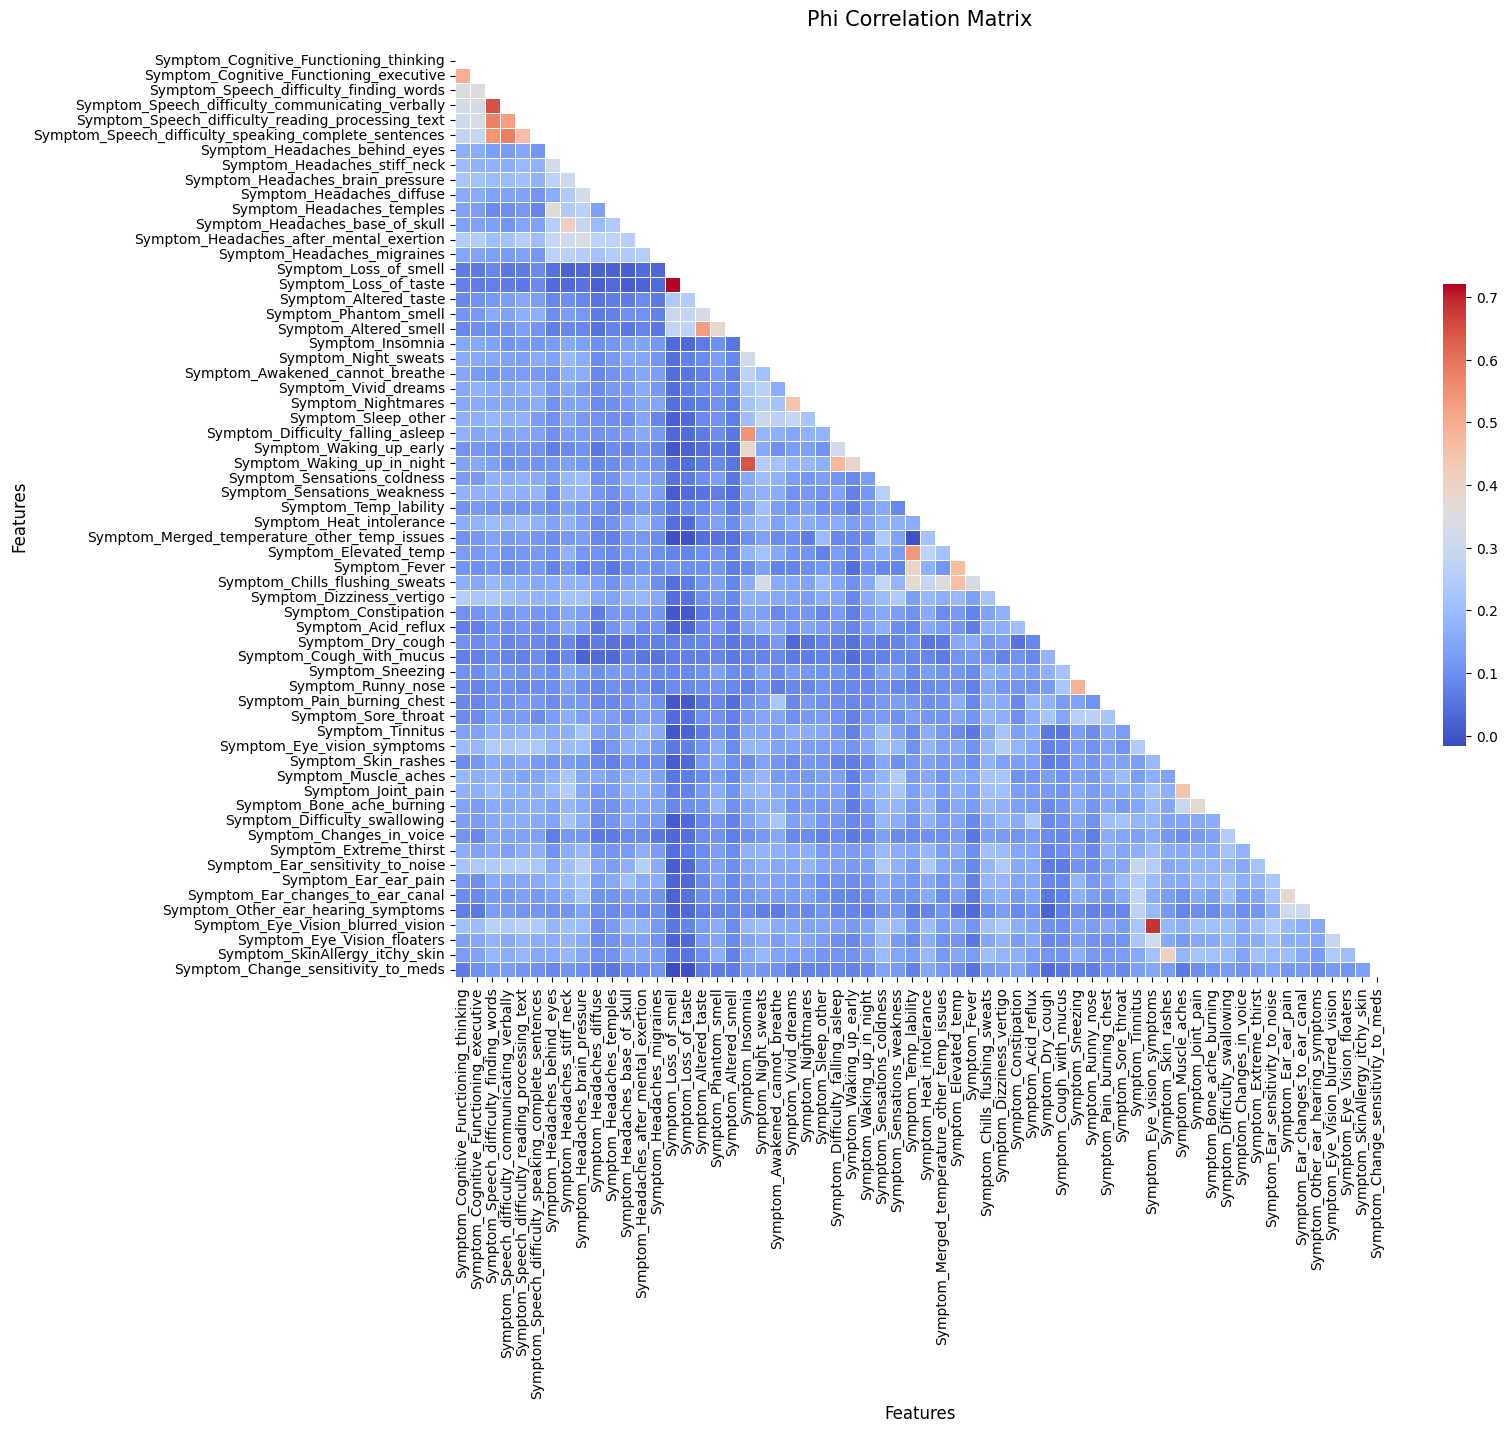

Correlated Feature Pairs (Phi Correlation > 0.5), Ordered by Correlation:
Symptom_Loss_of_smell - Symptom_Loss_of_taste: 0.72
Symptom_Eye_vision_symptoms - Symptom_Eye_Vision_blurred_vision: 0.68
Symptom_Speech_difficulty_finding_words - Symptom_Speech_difficulty_communicating_verbally: 0.65
Symptom_Insomnia - Symptom_Waking_up_in_night: 0.64
Symptom_Speech_difficulty_communicating_verbally - Symptom_Speech_difficulty_speaking_complete_sentences: 0.58
Symptom_Speech_difficulty_finding_words - Symptom_Speech_difficulty_reading_processing_text: 0.58
Symptom_Insomnia - Symptom_Difficulty_falling_asleep: 0.55
Symptom_Speech_difficulty_finding_words - Symptom_Speech_difficulty_speaking_complete_sentences: 0.55
Symptom_Temp_lability - Symptom_Elevated_temp: 0.54
Symptom_Altered_taste - Symptom_Altered_smell: 0.53
Symptom_Speech_difficulty_communicating_verbally - Symptom_Speech_difficulty_reading_processing_text: 0.52


In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to compute the phi coefficient for binary variables
def phi_coefficient(x, y):
    n11 = np.sum((x == 1) & (y == 1))
    n00 = np.sum((x == 0) & (y == 0))
    n10 = np.sum((x == 1) & (y == 0))
    n01 = np.sum((x == 0) & (y == 1))
    n = n11 + n00 + n10 + n01
    return (n11 * n00 - n10 * n01) / np.sqrt((n11 + n10) * (n01 + n00) * (n11 + n01) * (n10 + n00))

# Assuming 'dataset_no_skew' is your binary dataset
# Example: dataset_no_skew = pd.DataFrame(...)

# Compute the phi correlation matrix
phi_corr_matrix = pd.DataFrame(index=dataset_no_skew.columns, columns=dataset_no_skew.columns)
for col1 in dataset_no_skew.columns:
    for col2 in dataset_no_skew.columns:
        phi_corr_matrix.loc[col1, col2] = phi_coefficient(dataset_no_skew[col1], dataset_no_skew[col2])

# Plotting the heatmap
plt.figure(figsize=(15, 12))
mask = np.triu(np.ones_like(phi_corr_matrix, dtype=bool))
sns.heatmap(phi_corr_matrix.astype(float), mask=mask, cmap='coolwarm', annot=False, fmt='.2f', linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Phi Correlation Matrix', fontsize=15, pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

# Define a threshold for high correlation
correlation_threshold = 0.5

# Identify and print highly correlated pairs
correlated_pairs = []
for i, j in zip(*np.triu_indices_from(phi_corr_matrix, k=1)):
    if abs(float(phi_corr_matrix.iloc[i, j])) > correlation_threshold:
        correlated_pairs.append((phi_corr_matrix.columns[i], phi_corr_matrix.columns[j], phi_corr_matrix.iloc[i, j]))

correlated_pairs.sort(key=lambda pair: -abs(float(pair[2])))

print("Correlated Feature Pairs (Phi Correlation > 0.5), Ordered by Correlation:")
for pair in correlated_pairs:
    print(f"{pair[0]} - {pair[1]}: {float(pair[2]):.2f}")


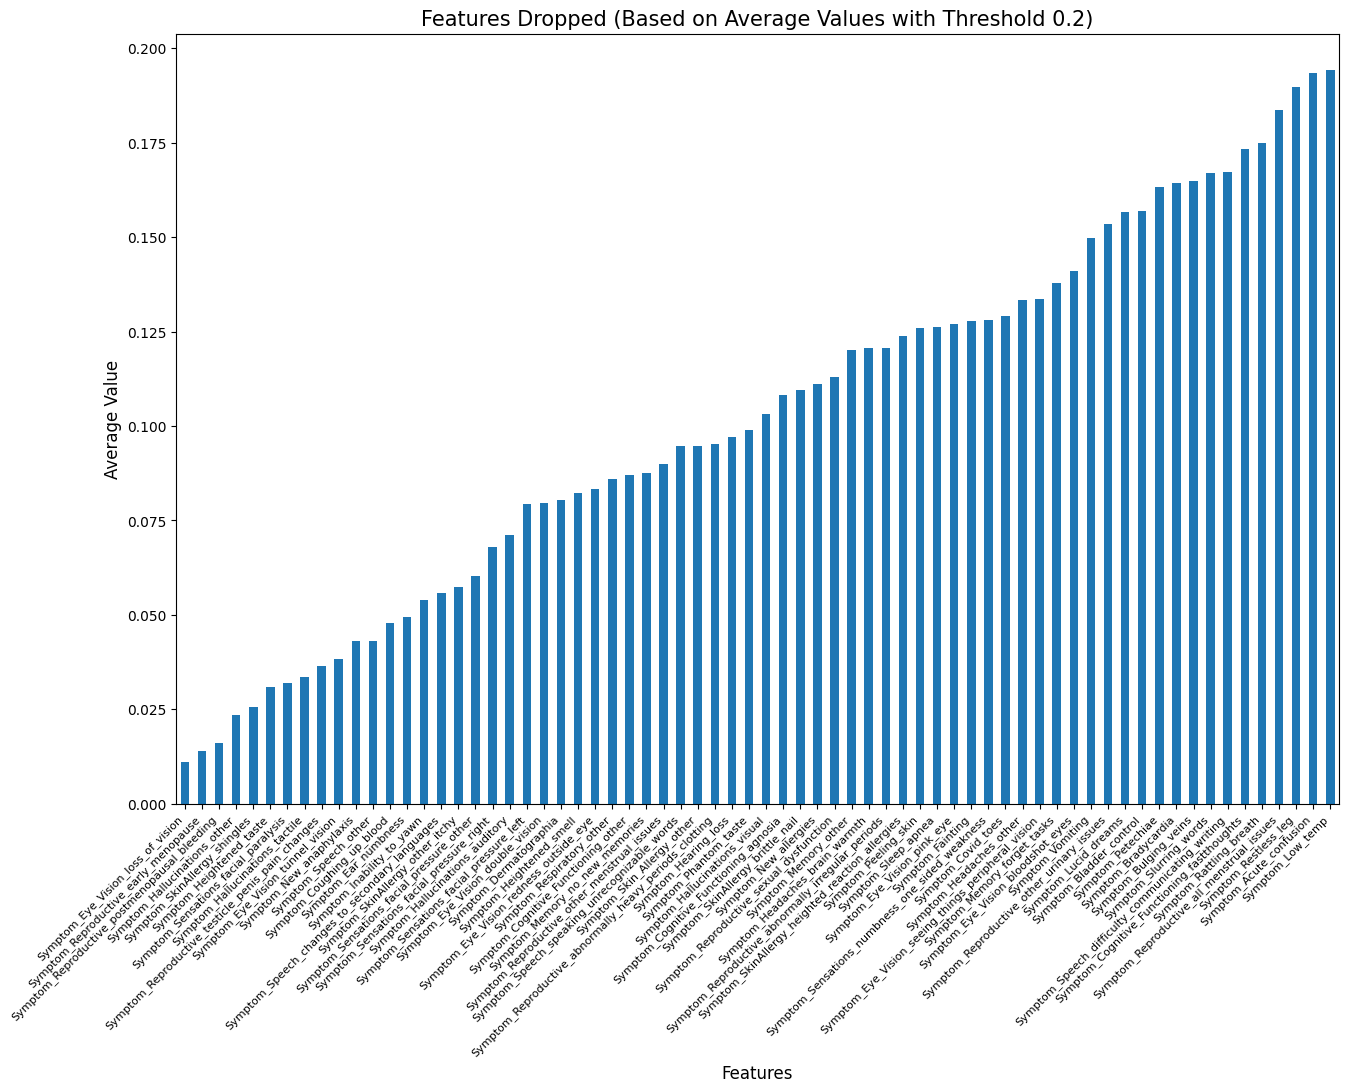

Features Dropped (Based on Average Values with Threshold 0.8): Symptom_Eye_Vision_loss_of_vision: 0.0111, Symptom_Reproductive_early_menopause: 0.0139, Symptom_Reproductive_postmenopausal_bleeding: 0.0161, Symptom_Hallucinations_other: 0.0234, Symptom_SkinAllergy_shingles: 0.0257, Symptom_Heightened_taste: 0.0308, Symptom_Sensations_facial_paralysis: 0.0320, Symptom_Hallucinations_tactile: 0.0337, Symptom_Reproductive_testicle_penis_pain_changes: 0.0365, Symptom_Eye_Vision_tunnel_vision: 0.0383, Symptom_New_anaphylaxis: 0.0429, Symptom_Speech_other: 0.0431, Symptom_Coughing_up_blood: 0.0479, Symptom_Ear_numbness: 0.0494, Symptom_Inability_to_yawn: 0.0541, Symptom_Speech_changes_to_secondary_languages: 0.0557, Symptom_SkinAllergy_other_itchy: 0.0574, Symptom_Sensations_facial_pressure_other: 0.0602, Symptom_Sensations_facial_pressure_right: 0.0680, Symptom_Hallucinations_auditory: 0.0711, Symptom_Sensations_facial_pressure_left: 0.0793, Symptom_Eye_Vision_double_vision: 0.0796, Symptom_

In [56]:
# Load your dataset
dataset = pd.read_csv(f'/Users/leo/Programming/PLR/Leo/data/dataset_{opt_params["dataset"]}.csv').drop('Unnamed: 0', axis=1)

# Calculate the average for each feature
feature_averages = dataset.mean()

# Identify features that would be dropped based on the provided threshold
threshold = opt_params['skew_threshold']  # Assuming this is defined in opt_params
dropped_features = feature_averages[(feature_averages > threshold) | (feature_averages < (1 - threshold))]

# Sort the dropped features in ascending order
sorted_dropped_features = dropped_features.sort_values(ascending=True)

# Create a bar plot for the features that were dropped
plt.figure(figsize=(15, 10))
sorted_dropped_features.plot(kind='bar')
plt.title(f'Features Dropped (Based on Average Values with Threshold {round(1 - threshold,2)})', fontsize=15)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Average Value', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate labels for better visibility and smaller size
plt.show()

# Print the dropped features and their averages
dropped_features_str = ', '.join([f"{feature}: {avg:.4f}" for feature, avg in sorted_dropped_features.items()])
print(f"Features Dropped (Based on Average Values with Threshold {threshold}): {dropped_features_str}")



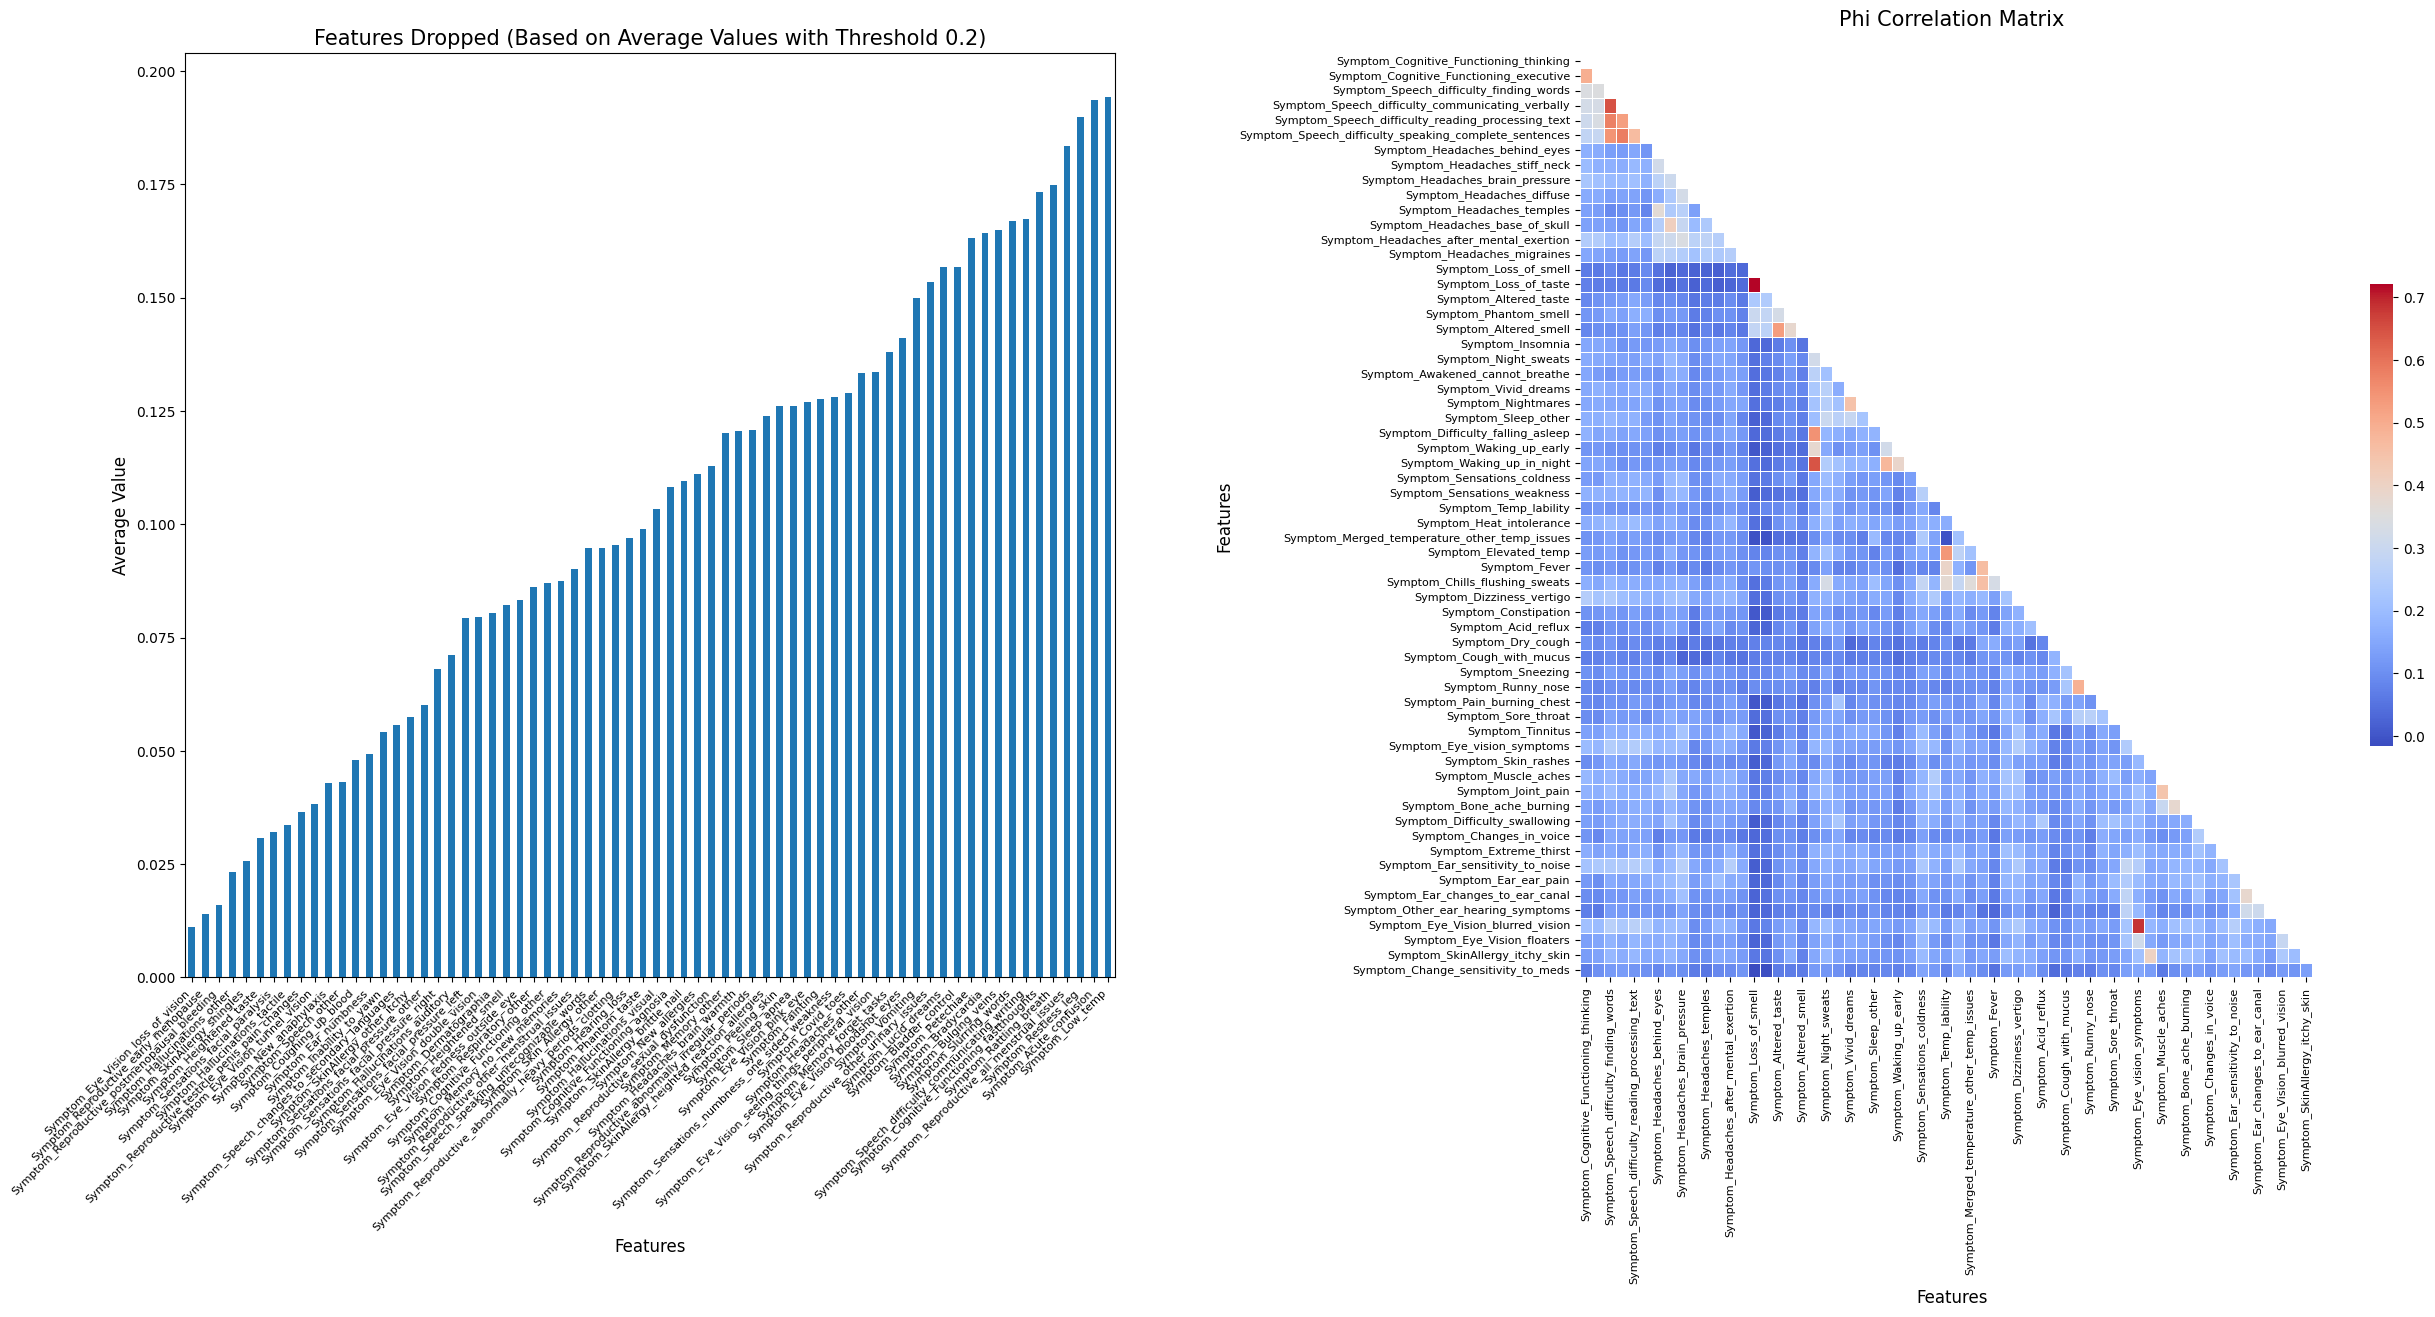

Correlated Feature Pairs (Phi Correlation > 0.5), Ordered by Correlation:
Symptom_Loss_of_smell - Symptom_Loss_of_taste: 0.72
Symptom_Eye_vision_symptoms - Symptom_Eye_Vision_blurred_vision: 0.68
Symptom_Speech_difficulty_finding_words - Symptom_Speech_difficulty_communicating_verbally: 0.65
Symptom_Insomnia - Symptom_Waking_up_in_night: 0.64
Symptom_Speech_difficulty_communicating_verbally - Symptom_Speech_difficulty_speaking_complete_sentences: 0.58
Symptom_Speech_difficulty_finding_words - Symptom_Speech_difficulty_reading_processing_text: 0.58
Symptom_Insomnia - Symptom_Difficulty_falling_asleep: 0.55
Symptom_Speech_difficulty_finding_words - Symptom_Speech_difficulty_speaking_complete_sentences: 0.55
Symptom_Temp_lability - Symptom_Elevated_temp: 0.54
Symptom_Altered_taste - Symptom_Altered_smell: 0.53
Symptom_Speech_difficulty_communicating_verbally - Symptom_Speech_difficulty_reading_processing_text: 0.52


In [73]:
# Load your dataset
dataset = pd.read_csv(f'/Users/leo/Programming/PLR/Leo/data/dataset_{opt_params["dataset"]}.csv').drop('Unnamed: 0', axis=1)

# Calculate the average for each feature
feature_averages = dataset.mean()

# Identify features that would be dropped based on the provided threshold
threshold = opt_params['skew_threshold']
dropped_features = feature_averages[(feature_averages > threshold) | (feature_averages < (1 - threshold))]

# Sort the dropped features in ascending order
sorted_dropped_features = dropped_features.sort_values(ascending=True)

# Assuming 'dataset_no_skew' is your binary dataset
# Compute the phi correlation matrix
phi_corr_matrix = pd.DataFrame(index=dataset_no_skew.columns, columns=dataset_no_skew.columns)
for col1 in dataset_no_skew.columns:
    for col2 in dataset_no_skew.columns:
        phi_corr_matrix.loc[col1, col2] = phi_coefficient(dataset_no_skew[col1], dataset_no_skew[col2])

# Define a threshold for high correlation
correlation_threshold = 0.5

# Identify highly correlated pairs
correlated_pairs = []
for i, j in zip(*np.triu_indices_from(phi_corr_matrix, k=1)):
    if abs(float(phi_corr_matrix.iloc[i, j])) > correlation_threshold:
        correlated_pairs.append((phi_corr_matrix.columns[i], phi_corr_matrix.columns[j], phi_corr_matrix.iloc[i, j]))

correlated_pairs.sort(key=lambda pair: -abs(float(pair[2])))

# Set up a matplotlib figure with subplots
plt.figure(figsize=(30, 12))  # Adjust size as needed

# Plot for dropped features
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
sorted_dropped_features.plot(kind='bar')
plt.title(f'Features Dropped (Based on Average Values with Threshold {round(1 - threshold,2)})', fontsize=15)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Average Value', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)

# Plot for phi correlation matrix
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
mask = np.triu(np.ones_like(phi_corr_matrix, dtype=bool))
sns.heatmap(phi_corr_matrix.astype(float), mask=mask, cmap='coolwarm', annot=False, fmt='.2f', linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title('Phi Correlation Matrix', fontsize=15, pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Adjust spacing with increased wspace
plt.subplots_adjust(wspace=0.5)  # Increased the width space

# Show the combined plot
plt.show()

# Print the correlated pairs
print("Correlated Feature Pairs (Phi Correlation > 0.5), Ordered by Correlation:")
for pair in correlated_pairs:
    print(f"{pair[0]} - {pair[1]}: {float(pair[2]):.2f}")


Correlation (Women vs Symptom count): 0.8829187134416479, P-value: 0.008450342381896611
Correlation (Women vs Physical PEM Severity): 0.9727272727272728, P-value: 0.00023248789660928963
Correlation (Women vs Cognitive PEM Severity): 0.8829187134416479, P-value: 0.008450342381896611


/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


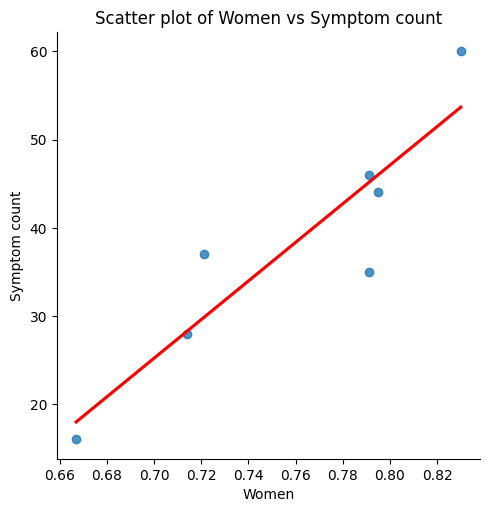

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


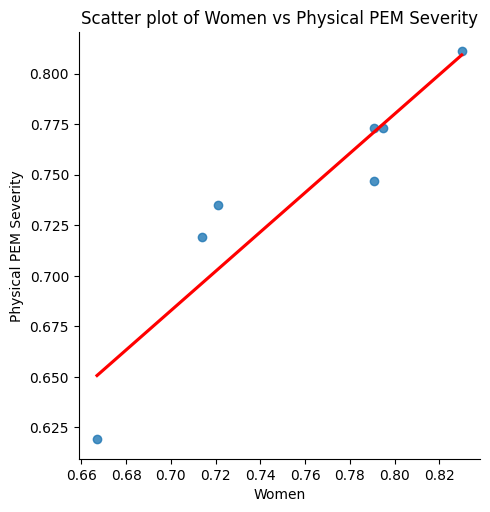

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


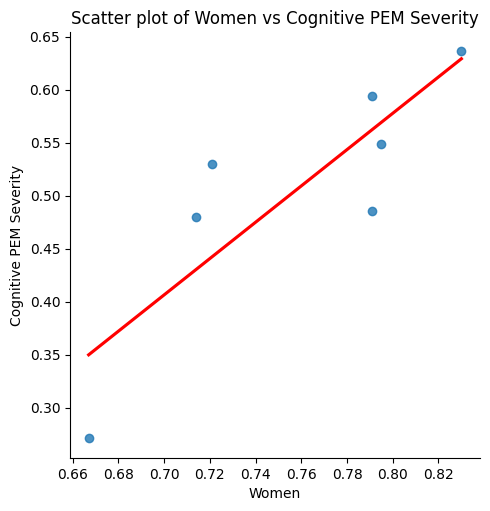

ValueError: could not convert string to float: 'AX'

In [64]:
import pandas as pd
from scipy.stats import spearmanr

# Sample data in a dictionary format
data = {
    'Cluster Name': ['AX', 'A0', 'A1', 'A2', 'A3', 'A4', 'A5'],
    'Size': [222, 1125, 2126, 321, 498, 850, 889],
    'Symptom count': [16, 44, 60, 35, 46, 28, 37],
    'Women': [0.667, 0.795, 0.830, 0.791, 0.791, 0.714, 0.721],
    'Physical PEM Severity': [0.619, 0.773, 0.811, 0.747, 0.773, 0.719, 0.735],
    'Cognitive PEM Severity': [0.271, 0.549, 0.636, 0.485, 0.594, 0.480, 0.530]
}

# Create DataFrame
df = pd.DataFrame(data)

# Function to calculate correlation and p-value
def calculate_correlation(df, column1, column2):
    correlation, p_value = spearmanr(df[column1], df[column2])
    return correlation, p_value

# Calculating correlations
correlation_symptom, p_symptom = calculate_correlation(df, 'Women', 'Symptom count')
correlation_physical, p_physical = calculate_correlation(df, 'Women', 'Physical PEM Severity')
correlation_cognitive, p_cognitive = calculate_correlation(df, 'Women', 'Cognitive PEM Severity')

# Displaying results
print(f"Correlation (Women vs Symptom count): {correlation_symptom}, P-value: {p_symptom}")
print(f"Correlation (Women vs Physical PEM Severity): {correlation_physical}, P-value: {p_physical}")
print(f"Correlation (Women vs Cognitive PEM Severity): {correlation_cognitive}, P-value: {p_cognitive}")

# Calculate correlation and p-value
def calculate_correlation(df, column1, column2):
    correlation, p_value = spearmanr(df[column1], df[column2])
    return correlation, p_value

# Scatter plots with trend lines
def plot_correlation(df, column1, column2):
    sns.lmplot(x=column1, y=column2, data=df, ci=None, order=1, line_kws={'color': 'red'})
    plt.title(f'Scatter plot of {column1} vs {column2}')
    plt.show()

# Display scatter plots
plot_correlation(df, 'Women', 'Symptom count')
plot_correlation(df, 'Women', 'Physical PEM Severity')
plot_correlation(df, 'Women', 'Cognitive PEM Severity')

# Heatmap for correlation matrix
correlation_matrix = df.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()


In [60]:
df

,Cluster Name,Size,Symptom count,Women,Physical PEM Severity,Cognitive PEM Severity
0,AX,222,16,0.667,0.619,0.271
1,A0,1125,44,0.795,0.773,0.549
2,A1,2126,60,0.830,0.811,0.636
3,A2,321,35,0.791,0.747,0.485
4,A3,498,46,0.791,0.773,0.594
5,A4,850,28,0.714,0.719,0.480
6,A5,889,37,0.721,0.735,0.530


In [63]:
from scipy.stats import shapiro

# Function to perform Shapiro-Wilk test

def test_normality(series):
    # Check if the series is numeric
    if pd.api.types.is_numeric_dtype(series):
        stat, p = shapiro(series)
        print(f'Statistics={stat}, p={p}')
        alpha = 0.05
        if p > alpha:
            print('Sample looks Gaussian (fail to reject H0)')
        else:
            print('Sample does not look Gaussian (reject H0)')
    else:
        print('Non-numeric data, Shapiro-Wilk test not applicable')

# Testing normality for each column
for column in df.columns:
    print(f'\nTesting normality for {column}:')
    test_normality(df[column])


Testing normality for Cluster Name:
Non-numeric data, Shapiro-Wilk test not applicable

Testing normality for Size:
Statistics=0.8814458847045898, p=0.2329438030719757
Sample looks Gaussian (fail to reject H0)

Testing normality for Symptom count:
Statistics=0.9894916415214539, p=0.9922361969947815
Sample looks Gaussian (fail to reject H0)

Testing normality for Women:
Statistics=0.9102931618690491, p=0.3979073762893677
Sample looks Gaussian (fail to reject H0)

Testing normality for Physical PEM Severity:
Statistics=0.8931599259376526, p=0.29155510663986206
Sample looks Gaussian (fail to reject H0)

Testing normality for Cognitive PEM Severity:
Statistics=0.8805515170097351, p=0.2289072573184967
Sample looks Gaussian (fail to reject H0)


In [65]:
import pandas as pd

# Define the data
data = {
    'Comparison': ['Women vs Symptom count', 'Women vs Physical PEM Severity', 'Women vs Cognitive PEM Severity'],
    'Correlation': [0.8829187134416479, 0.9727272727272728, 0.8829187134416479],
    'P-value': [0.008450342381896611, 0.00023248789660928963, 0.008450342381896611]
}

# Create a DataFrame
correlation_table = pd.DataFrame(data)

# Display the table
print(correlation_table)


                        Comparison  Correlation   P-value
0           Women vs Symptom count     0.882919  0.008450
1   Women vs Physical PEM Severity     0.972727  0.000232
2  Women vs Cognitive PEM Severity     0.882919  0.008450
